In [1]:
# import needed libraries
import sys
import os 
import pickle
from collections import OrderedDict
from matplotlib import pyplot as plt
import numpy as np 
import pandas as pd
# path of local project
folder_path = "/home/jiaxiangyi/Documents/rvesimulator"
sys.path.insert(0, folder_path) 

# import local packages and functions 
import rvesimulator 
from rvesimulator.simulators.pnas_hollow_plate_rve import PnasHollowPlateRVE
from rvesimulator.design_of_experiment.samplers import FixNumberSampler
from rvesimulator.simulators.path_generator import PathGenerator


# Illustation on the mechanism of load path generator

**load path generator** 
1. There are many ways to generate the time dependent path such as Monte Carlo method, interpolation method, and so on. In this work, the interpolation method is adopted. 

2. For the interpolation method, there are several features to control the final path which are: 
- Number of control points 
- interpolation method,such as the linear interpolation method or quadratic interpolation method 
- number of increment points which used to determine the length of the loads path


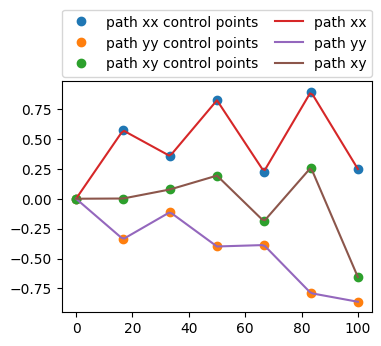

In [2]:
# show to use the path generator to generate the path loads 
path_generater = PathGenerator(num_control_points=7, num_increment=100) 
# linear interpolate 
path_linear = path_generater.linear_interpolate() 
path_generater.plot_path() 

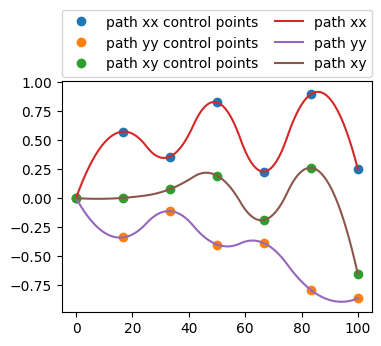

In [3]:
# linear interpolate 
path_quadratic = path_generater.quadratic_interpolate()
path_generater.plot_path()  

# Illustrate how to generate path-dependent simulation data for a hollow plate RVE 

The aim of use the design of experiment modulus is that I want to create a dict that contains the samples and the responses. 
- samples: a pandas Dataframe contains the input information, later the path information also should be added into the samples Dataframe 
- responses : a pandas Dataframe contains the output information 


In [4]:
# design of experiments 
# here the design variable is set to be the number of control points for loads path 
# therefore the 
doe_variables = OrderedDict({"control_points": 7})

# define number of samples, which means three different path will be generated 
num_points = 3 

# define the information of outputs
name_outputs = ["stress", "strain", "plastic_energy"]
doe_sampler = FixNumberSampler()
doe_sampler.sampling(
    num_samples=num_points,
    design_space=doe_variables,
    out_names=name_outputs,
    seed=123456,
)
data = doe_sampler.data
data = doe_sampler.data
print(doe_sampler.data)


{'samples':    control_points
0             7.0
1             7.0
2             7.0, 'responses':   stress strain plastic_energy
0    NaN    NaN            NaN
1    NaN    NaN            NaN
2    NaN    NaN            NaN}


**Add the loads path to the samples pandas Dataframe in the 'data' dict**
- Because it pretty hard to sample the loads path directly from the design of experiment methods, in this case, we add one more colume in the samples Dataframe called "loads_path" 

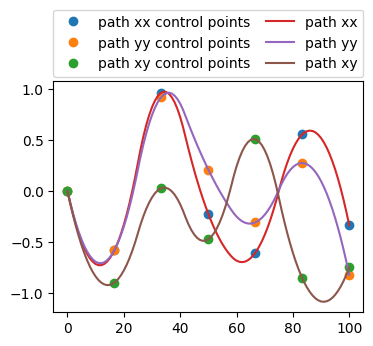

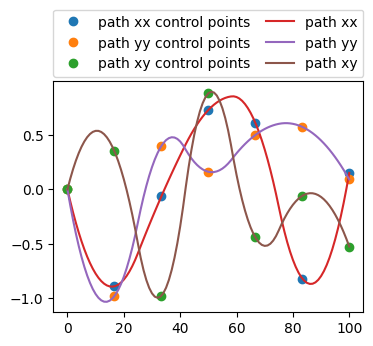

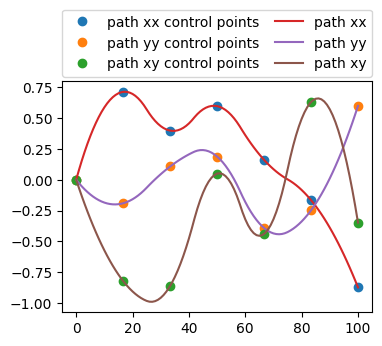

   control_points                                         loads_path
0             7.0  [[0.0, -0.12128881212737332, -0.23155665924333...
1             7.0  [[0.0, -0.10956403586628215, -0.21195123651713...
2             7.0  [[0.0, 0.08018038780828819, 0.1555796453528661...


In [5]:
# create an empty dataframe that contain the keys of loads_path
loads_path_temp = np.empty([num_points, 1])
loads_path_temp[:] = np.nan
loads_path = pd.DataFrame(loads_path_temp, columns=["loads_path"])
loads_path["loads_path"] = loads_path["loads_path"].astype(object)

# define the path generator
for ii in range(num_points):
    path_generator = PathGenerator(num_control_points=data["samples"].at[ii, "control_points"])
    loads_path.iloc[ii, 0] = path_generator.quadratic_interpolate()
    path_generator.plot_path()

# add the loads path to the samples
data["samples"] = pd.concat([data["samples"], loads_path], axis=1, join="inner") 
print(data["samples"])

In [6]:
# load the abaqus simulation modulus and run the simulation 
simulation_wrapper = PnasHollowPlateRVE()
simulation_wrapper.update_sim_info(print_info=True, mesh_partition=100, num_cpu=6)

The simulation information is : {'length': 1.0, 'width': 1.0, 'radius': 0.2, 'youngs_modulus': 100.0, 'poission_ratio': 0.3, 'yield_table': [[0.5, 0.5316978638492222, 0.541825582103651, 0.5491901897169873, 0.5551891864584486, 0.5603417633654516, 0.5649068444639842, 0.5690349813196016, 0.5728225681210433, 0.5763355781923636, 0.5796214341106994, 0.5827155324558011, 0.585645094733533, 0.5884315702256371, 0.5910922039712734, 0.5936410984009242, 0.5960899547185146, 0.5984486044506366, 0.6007253992982465, 0.6029275027715475, 0.6050611121761507, 0.6071316302061533, 0.6091437994192216, 0.6111018089314695, 0.6130093800197907, 0.6148698354997035, 0.616686156474797, 0.6184610291500892, 0.6201968837498333, 0.6218959271038169, 0.6235601701134824, 0.6251914510450486, 0.6267914553968891, 0.6283617329355872, 0.6299037123771667, 0.6314187140982368, 0.6329079611897948, 0.6343725891095284, 0.635813654143156, 0.6372321408490402, 0.6386289686310292, 0.6400049975607272, 0.6413610335510157, 0.642697832966753

In [7]:
data = simulation_wrapper.run_simulation(data=data)

Current working directory: /home/jiaxiangyi/Documents/rvesimulator/examples/pnas_hollow_plate/basic_illustation/Data/point_0
##################################################
############# START ABAQUS ANALYSIS #############
##################################################


Abaqus License Manager checked out the following license:
"cae" from Flexnet server flexserv1.tudelft.nl
<11 out of 30 licenses remain available>.


the simulation time is :40.00689101219177 !
the simulation time is :60.018401861190796 !
the simulation time is :80.01885867118835 !
the simulation time is :100.01847672462463 !
the simulation time is :120.0191559791565 !
the simulation time is :140.01877856254578 !
the simulation time is :160.01863431930542 !
the simulation time is :180.01884293556213 !
Simulation successfully finished! 


*** ABAQUS/ABQcaeK rank 0 terminated by signal 15 (Terminated)

0
time cost of this iteraion: 200.08830785751343
##################################################
########### START ABAQUS POST ANALYSIS ###########
##################################################
Abaqus Error: cae exited with an error.


Abaqus License Manager checked out the following license:
"cae" from Flexnet server flexserv1.tudelft.nl
<11 out of 30 licenses remain available>.


Current working directory: /home/jiaxiangyi/Documents/rvesimulator/examples/pnas_hollow_plate/basic_illustation/Data/point_1
##################################################
############# START ABAQUS ANALYSIS #############
##################################################


Abaqus License Manager checked out the following license:
"cae" from Flexnet server flexserv1.tudelft.nl
<11 out of 30 licenses remain available>.


the simulation time is :40.00968289375305 !
the simulation time is :60.01883006095886 !
the simulation time is :80.01791644096375 !
the simulation time is :100.01823163032532 !
the simulation time is :120.01812696456909 !
the simulation time is :140.01788783073425 !
the simulation time is :160.01788091659546 !
the simulation time is :180.01986169815063 !
the simulation time is :200.02038836479187 !
the simulation time is :220.02023911476135 !
the simulation time is :240.0182077884674 !
Simulation successfully finished! 


*** ABAQUS/ABQcaeK rank 0 terminated by signal 15 (Terminated)

0
time cost of this iteraion: 260.0842192173004
##################################################
########### START ABAQUS POST ANALYSIS ###########
##################################################
Abaqus Error: cae exited with an error.


Abaqus License Manager checked out the following license:
"cae" from Flexnet server flexserv1.tudelft.nl
<11 out of 30 licenses remain available>.


Current working directory: /home/jiaxiangyi/Documents/rvesimulator/examples/pnas_hollow_plate/basic_illustation/Data/point_2
##################################################
############# START ABAQUS ANALYSIS #############
##################################################


Abaqus License Manager checked out the following license:
"cae" from Flexnet server flexserv1.tudelft.nl
<11 out of 30 licenses remain available>.


the simulation time is :40.00762987136841 !
the simulation time is :60.01949429512024 !
the simulation time is :80.01974701881409 !
the simulation time is :100.0196123123169 !
the simulation time is :120.01965355873108 !
the simulation time is :140.01991200447083 !
the simulation time is :160.01967072486877 !
the simulation time is :180.02022290229797 !
the simulation time is :200.02069401741028 !
Simulation successfully finished! 


*** ABAQUS/ABQcaeK rank 0 terminated by signal 15 (Terminated)

0
time cost of this iteraion: 220.09577989578247
##################################################
########### START ABAQUS POST ANALYSIS ###########
##################################################
Abaqus Error: cae exited with an error.


Abaqus License Manager checked out the following license:
"cae" from Flexnet server flexserv1.tudelft.nl
<10 out of 30 licenses remain available>.


In [8]:
# print the data information 
print(data["responses"])

                                              stress  \
0  [[[0.0, 0.0], [0.0, 0.0]], [[-0.32244145089936...   
1  [[[0.0, 0.0], [0.0, 0.0]], [[-0.32778460287354...   
2  [[[0.0, 0.0], [0.0, 0.0]], [[0.147026038549728...   

                                              strain  \
0  [[[0.0, 0.0], [0.0, 0.0]], [[-0.00241974484850...   
1  [[[0.0, 0.0], [0.0, 0.0]], [[-0.00218696679318...   
2  [[[0.0, 0.0], [0.0, 0.0]], [[0.001605819252610...   

                                      plastic_energy  
0  [[0.0, 0.0], [0.009999999776482582, 6.85420745...  
1  [[0.0, 0.0], [0.009999999776482582, 5.90783674...  
2  [[0.0, 0.0], [0.009999999776482582, 3.65117465...  


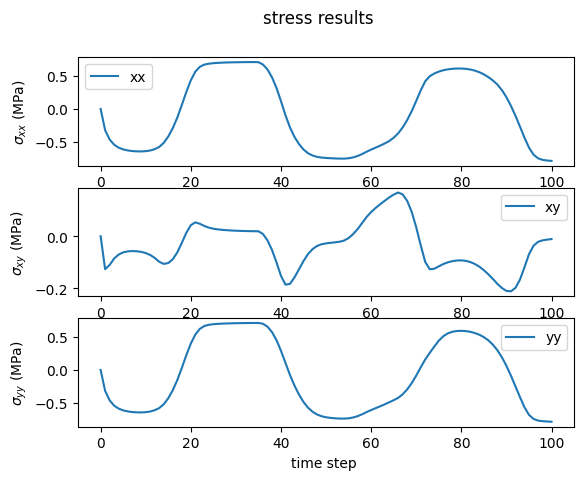

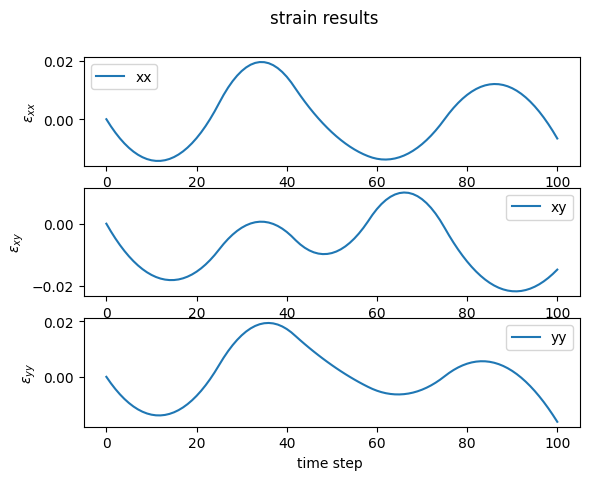

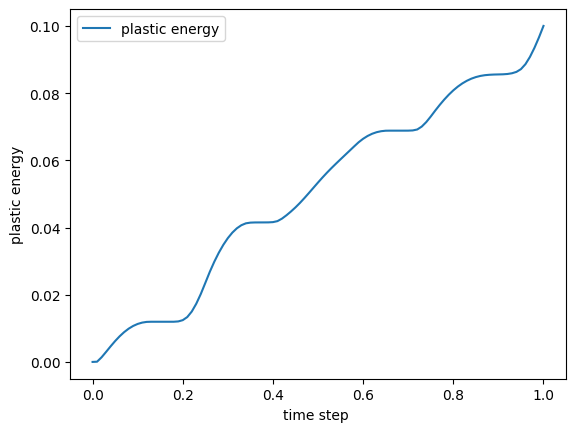

In [9]:
# post process for plotting the figures

# simulation results for the first sample
results = data["responses"]

stress = results["stress"].iloc[0]
strain = results["strain"].iloc[0]
plastic_energy = results["plastic_energy"].iloc[0]

pparam = dict(xlabel='time step ', ylabel="$\sigma_{xx}$ (MPa)")
fig, ax = plt.subplots(3,1)
ax[0].plot(stress[:, 0, 0], label="xx") 
ax[0].legend()
ax[0].set(**pparam)
pparam = dict(xlabel='time step ', ylabel="$\sigma_{xy}$ (MPa)")
ax[1].plot(stress[:, 1, 0], label="xy")
ax[1].legend()
ax[1].set(**pparam)
pparam = dict(xlabel='time step ', ylabel="$\sigma_{yy}$ (MPa)")
ax[2].plot(stress[:, 1, 1], label="yy") 
ax[2].legend()
ax[2].set(**pparam)
fig.suptitle('stress results')
# plt.show()
plt.savefig('stress.png', dpi=300)


pparam = dict(xlabel='time step ', ylabel="$\epsilon_{xx}$")
fig, ax = plt.subplots(3,1)
ax[0].plot(strain[:, 0, 0], label="xx") 
ax[0].legend()
ax[0].set(**pparam)
pparam = dict(xlabel='time step ', ylabel="$\epsilon_{xy}$")
ax[1].plot(strain[:, 0, 1], label="xy")
ax[1].legend()
ax[1].set(**pparam)
pparam = dict(xlabel='time step ', ylabel="$\epsilon_{yy}$")
ax[2].plot(strain[:, 1, 1], label="yy") 
ax[2].legend()
ax[2].set(**pparam)
fig.suptitle('strain results')
plt.savefig('strain.png', dpi=300)

pparam = dict(xlabel='time step ', ylabel="plastic energy")
fig, ax = plt.subplots()
ax.plot(plastic_energy[:,0], plastic_energy[:,1], label="plastic energy") 
ax.legend()
ax.set(**pparam)
plt.savefig('energy.png', dpi=300)

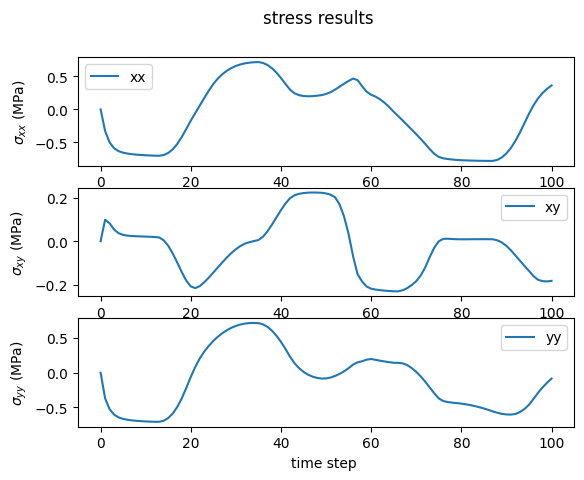

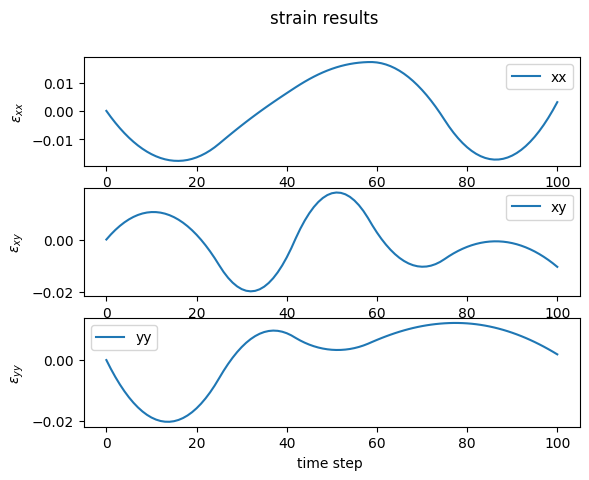

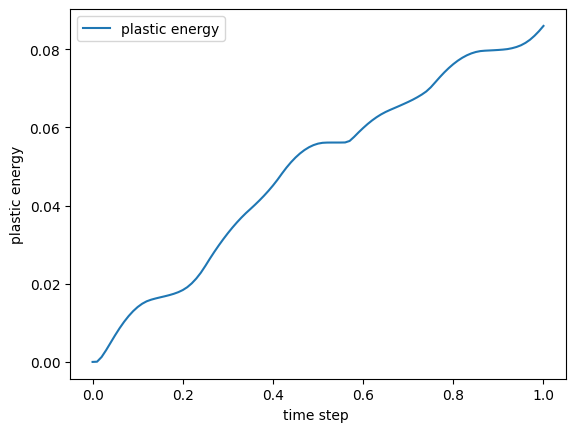

In [10]:
# post process for plotting the figures

# simulation results for the first sample
results = data["responses"]

stress = results["stress"].iloc[1]
strain = results["strain"].iloc[1]
plastic_energy = results["plastic_energy"].iloc[1]

pparam = dict(xlabel='time step ', ylabel="$\sigma_{xx}$ (MPa)")
fig, ax = plt.subplots(3,1)
ax[0].plot(stress[:, 0, 0], label="xx") 
ax[0].legend()
ax[0].set(**pparam)
pparam = dict(xlabel='time step ', ylabel="$\sigma_{xy}$ (MPa)")
ax[1].plot(stress[:, 1, 0], label="xy")
ax[1].legend()
ax[1].set(**pparam)
pparam = dict(xlabel='time step ', ylabel="$\sigma_{yy}$ (MPa)")
ax[2].plot(stress[:, 1, 1], label="yy") 
ax[2].legend()
ax[2].set(**pparam)
fig.suptitle('stress results')
# plt.show()
plt.savefig('stress.png', dpi=300)


pparam = dict(xlabel='time step ', ylabel="$\epsilon_{xx}$")
fig, ax = plt.subplots(3,1)
ax[0].plot(strain[:, 0, 0], label="xx") 
ax[0].legend()
ax[0].set(**pparam)
pparam = dict(xlabel='time step ', ylabel="$\epsilon_{xy}$")
ax[1].plot(strain[:, 0, 1], label="xy")
ax[1].legend()
ax[1].set(**pparam)
pparam = dict(xlabel='time step ', ylabel="$\epsilon_{yy}$")
ax[2].plot(strain[:, 1, 1], label="yy") 
ax[2].legend()
ax[2].set(**pparam)
fig.suptitle('strain results')
plt.savefig('strain.png', dpi=300)

pparam = dict(xlabel='time step ', ylabel="plastic energy")
fig, ax = plt.subplots()
ax.plot(plastic_energy[:,0], plastic_energy[:,1], label="plastic energy") 
ax.legend()
ax.set(**pparam)
plt.savefig('energy.png', dpi=300)

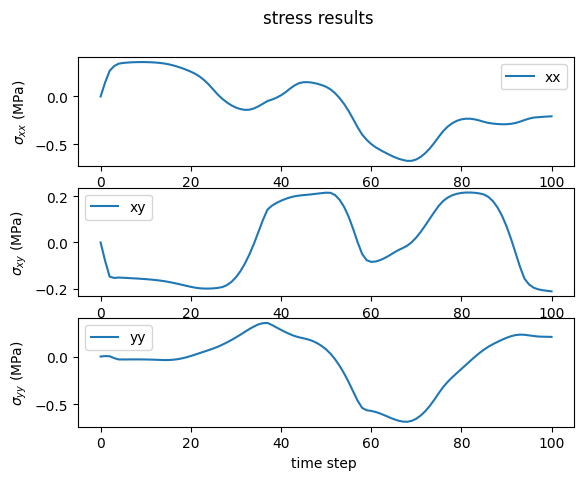

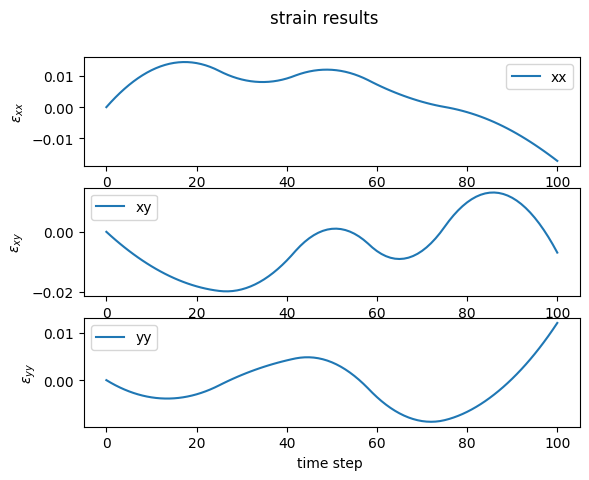

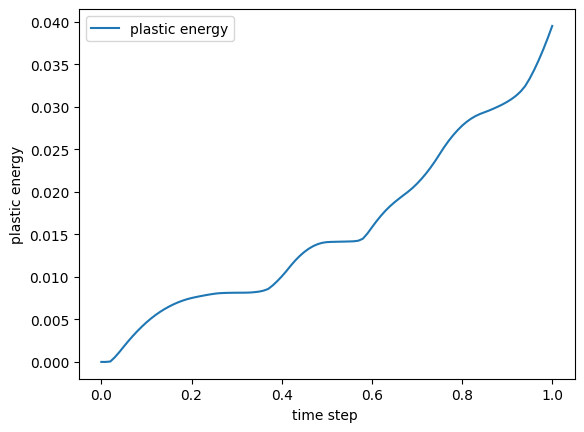

In [11]:
# post process for plotting the figures

# simulation results for the third sample
results = data["responses"]

stress = results["stress"].iloc[2]
strain = results["strain"].iloc[2]
plastic_energy = results["plastic_energy"].iloc[2]

pparam = dict(xlabel='time step ', ylabel="$\sigma_{xx}$ (MPa)")
fig, ax = plt.subplots(3,1)
ax[0].plot(stress[:, 0, 0], label="xx") 
ax[0].legend()
ax[0].set(**pparam)
pparam = dict(xlabel='time step ', ylabel="$\sigma_{xy}$ (MPa)")
ax[1].plot(stress[:, 1, 0], label="xy")
ax[1].legend()
ax[1].set(**pparam)
pparam = dict(xlabel='time step ', ylabel="$\sigma_{yy}$ (MPa)")
ax[2].plot(stress[:, 1, 1], label="yy") 
ax[2].legend()
ax[2].set(**pparam)
fig.suptitle('stress results')
# plt.show()
plt.savefig('stress.png', dpi=300)


pparam = dict(xlabel='time step ', ylabel="$\epsilon_{xx}$")
fig, ax = plt.subplots(3,1)
ax[0].plot(strain[:, 0, 0], label="xx") 
ax[0].legend()
ax[0].set(**pparam)
pparam = dict(xlabel='time step ', ylabel="$\epsilon_{xy}$")
ax[1].plot(strain[:, 0, 1], label="xy")
ax[1].legend()
ax[1].set(**pparam)
pparam = dict(xlabel='time step ', ylabel="$\epsilon_{yy}$")
ax[2].plot(strain[:, 1, 1], label="yy") 
ax[2].legend()
ax[2].set(**pparam)
fig.suptitle('strain results')
plt.savefig('strain.png', dpi=300)

pparam = dict(xlabel='time step ', ylabel="plastic energy")
fig, ax = plt.subplots()
ax.plot(plastic_energy[:,0], plastic_energy[:,1], label="plastic energy") 
ax.legend()
ax.set(**pparam)
plt.savefig('energy.png', dpi=300)